## Modified Slim

In [13]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import os
import deepxde as dde
from utils.gs_solovev_sol import GS_Linear

from deepxde.backend import set_default_backend
set_default_backend("pytorch") 

######################
# ITER Configuration #
######################
A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33
# A = -0.155
# eps = 0.2  
# kappa = 1.7 
# delta = 0.5 

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    # these are the R and Z in equantion (8) in paper
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    # computes the residual of the Grad-Shafranov equation
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

# changed center to (0,0)
spatial_domain = dde.geometry.Ellipse(np.array([0.0,0.0]), eps, kappa, delta) 

x,u = gen_traindata(1001)   #  red dots in the boundary

n_test = 100

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - delta * eps, kappa * eps],
                        [1 - delta * eps, -kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

observe_x = np.concatenate((x,observe_x))
observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=1024,        # blue dots in paper
    num_boundary=0,        
    num_test=n_test,
    train_distribution="LHS"
)


# net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

# model = dde.Model(data, net)


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


/Users/yuxiangxue/anaconda3/envs/deepxde/lib/python3.10/site-packages/deepxde/geometry/geometry_2d.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  self.focus1 = np.array(
/Users/yuxiangxue/anaconda3/envs/deepxde/lib/python3.10/site-packages/deepxde/geometry/geometry_2d.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  self.focus2 = np.array(


Text(0, 0.5, '$u(r,z=0)$')

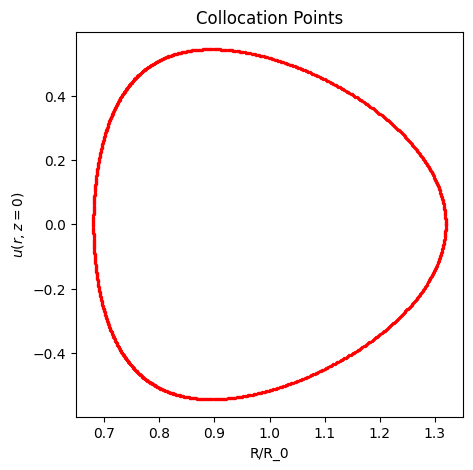

In [14]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

## Train Model

In [15]:
dde.backend.set_default_backend("pytorch") 

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Compiling model...
Building feed-forward neural network...
'build' took 0.273928 s

'compile' took 1.830320 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.75e+02, 3.52e-02]    [4.14e-01, 3.52e-02]    []  
1         [2.58e+01, 5.20e-02]    [8.08e-02, 5.20e-02]    []  
2         [9.76e+01, 9.53e-02]    [2.49e-01, 9.53e-02]    []  
3         [5.19e+01, 4.71e-02]    [1.39e-01, 4.71e-02]    []  
4         [9.21e+00, 7.95e-03]    [3.84e-02, 7.95e-03]    []  
5         [3.63e-01, 1.13e-03]    [1.87e-02, 1.13e-03]    []  
6         [9.37e+00, 1.29e-02]    [4.17e-02, 1.29e-02]    []  
7         [1.85e+01, 2.63e-02]    [6.48e-02, 2.63e-02]    []  
8         [2.04e+01, 3.24e-02]    [7.05e-02, 3.24e-02]    []  
9         [1.63e+01, 3.07e-02]    [6.13e-02, 3.07e-02]    []  
10        [1.00e+01, 2.41e-02]    [4.63e-02, 2.41e-02]    []  
11        [4.62e+00, 1.59e-02]    [3.24e-02, 1.59e-02]    []  
12        [1.27e+00, 8.68e-03]    [2.29e-02,

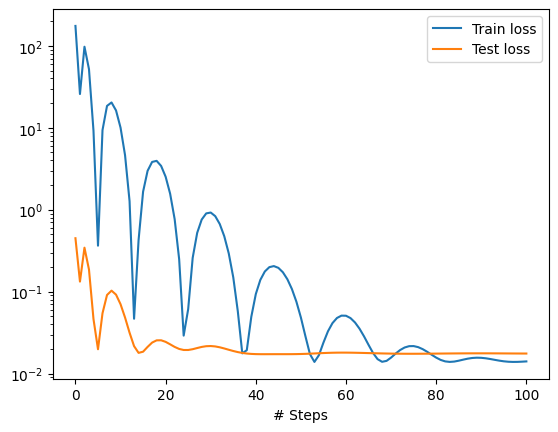

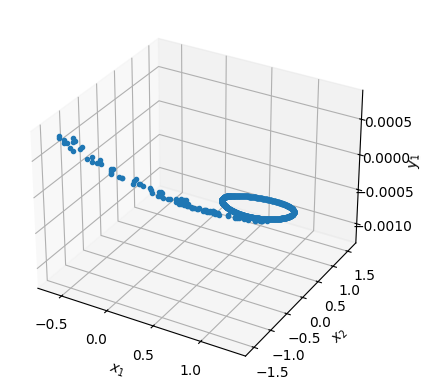

Accuracy
Mean residual: 1.0484278
Mean residual for output: 0.00022647303


In [16]:
import torch
import time
torch.set_default_tensor_type(torch.FloatTensor)
DATE = time.strftime("%m%d%Y")
CONFIG = "ITER"
LR = 2e-3   # 2e-2
DROPOUT = 0.1
DEPTH = 6  # 3
BREADTH = 64  # 20
LOSSRATIO = 200  # 100  # this is lamda1 in the paper
run = f"02_{LOSSRATIO}Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"
PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"

# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], AF, "Glorot normal",
    # dropout_rate=DROPOUT         # AttributeError: `dropout` is not available with Keras 3.
)

data.train_x_bc = data.train_x_bc.astype(np.float32)
data.train_x = data.train_x.astype(np.float32)

model = dde.Model(data, net)

decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,LOSSRATIO]
  )
  loss_history, train_state = model.train(
      epochs=100, display_every=1, #callbacks=[dde.callbacks.DropoutUncertainty()]
  )
  dde.saveplot(
      loss_history, 
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T.astype(np.float64)  # astype(np.float32)
output = model.predict(X)   # is the magnetic flux function psi
GS = model.predict(X, operator=pde_solovev)  # is the residual of the Grad-Shafranov equation
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)
print("Mean residual for output:", np.mean(np.absolute(output)))

## Plotting

#### Before BFGS

(501, 501)
Average normalized percent error =  370.8209143807279
Max normalized percent error =  632.6889012158946


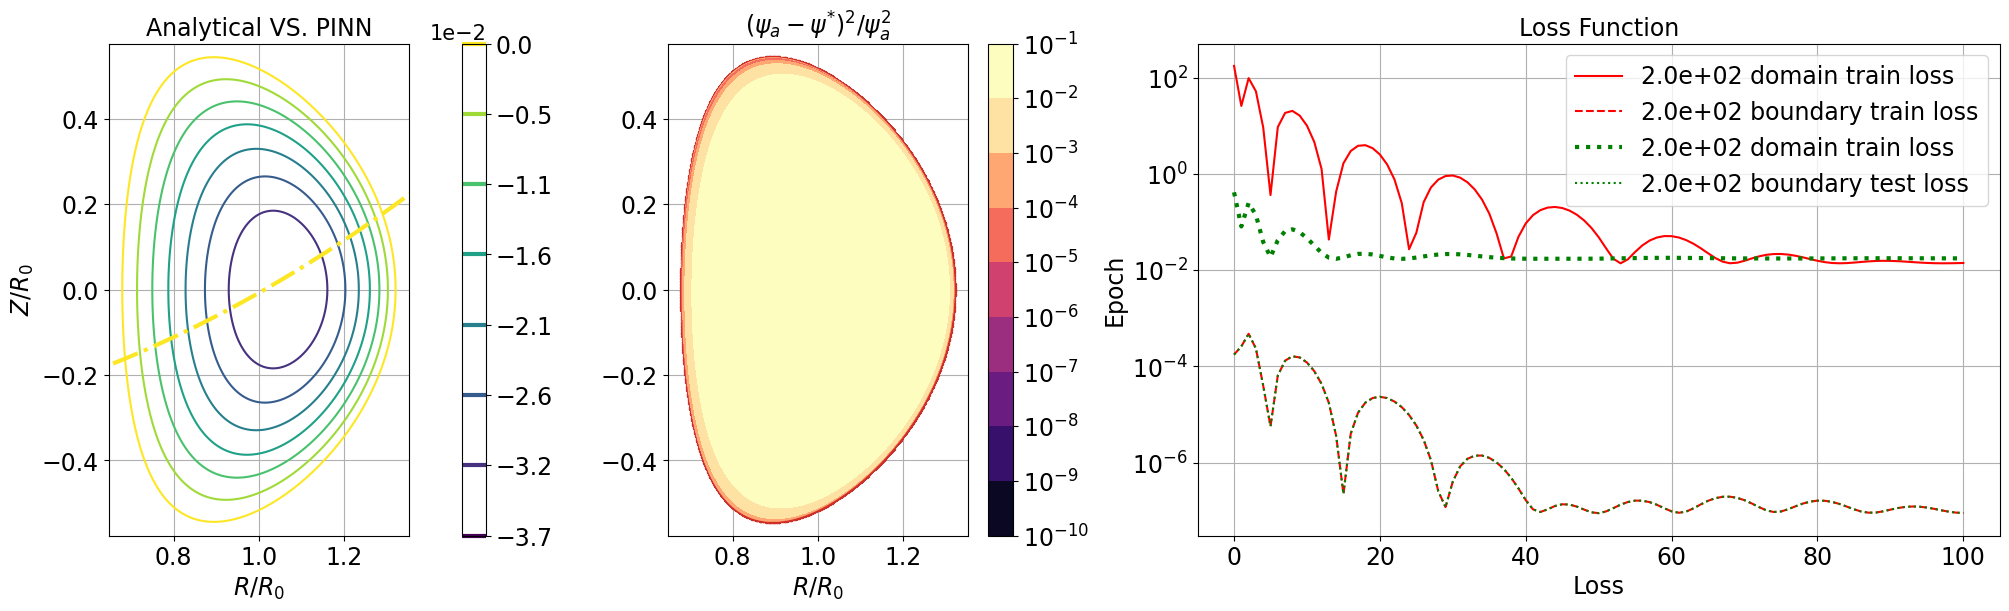

In [17]:
# Evaluation
from utils.utils import *
ITER = GS_Linear(eps=0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test=X_test, losshistory = loss_history, loss_ratio = LOSSRATIO, PATH = PATH)

#### After BFGS

Compiling model...
'compile' took 2.259840 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.41e-02, 9.00e-06]    [1.76e-02, 9.00e-06]    []  
110       [1.41e-02, 9.00e-06]    [1.41e-02, 9.00e-06]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  Objective function value: 0.014086
  Number of iterations: 1
  Number of functions evaluations: 29
117       [1.41e-02, 9.00e-06]    [1.76e-02, 9.00e-06]    []  

Best model at step 53:
  train loss: 1.39e-02
  test loss: 1.76e-02
  test metric: []

'train' took 4.223824 s

Saving loss history to ./cefron/ITER/runs/network_sweep_02272025_depth06_breadth64_swish_lr0.002-varying-short_lw1-10_02_200Adam_BFGS/loss.dat ...
Saving training data to ./cefron/ITER/runs/network_sweep_02272025_depth06_breadth64_swish_lr0.002-varying-short_lw1-10_02_200Adam_BFGS/train.dat ...
Saving test data to ./cefron/ITER/runs/network_sweep_022

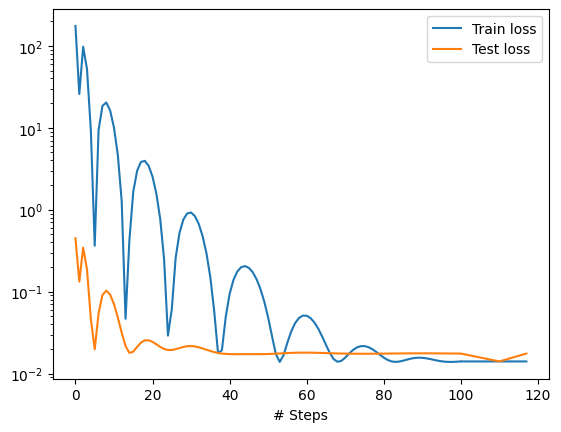

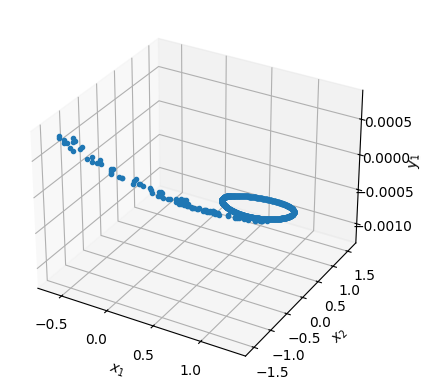

In [18]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(
    epochs=1000, display_every=10, #callbacks=[dde.callbacks.DropoutUncertainty()]
)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)

(501, 501)
Average normalized percent error =  406.1162661720883
Max normalized percent error =  680.8496042506778


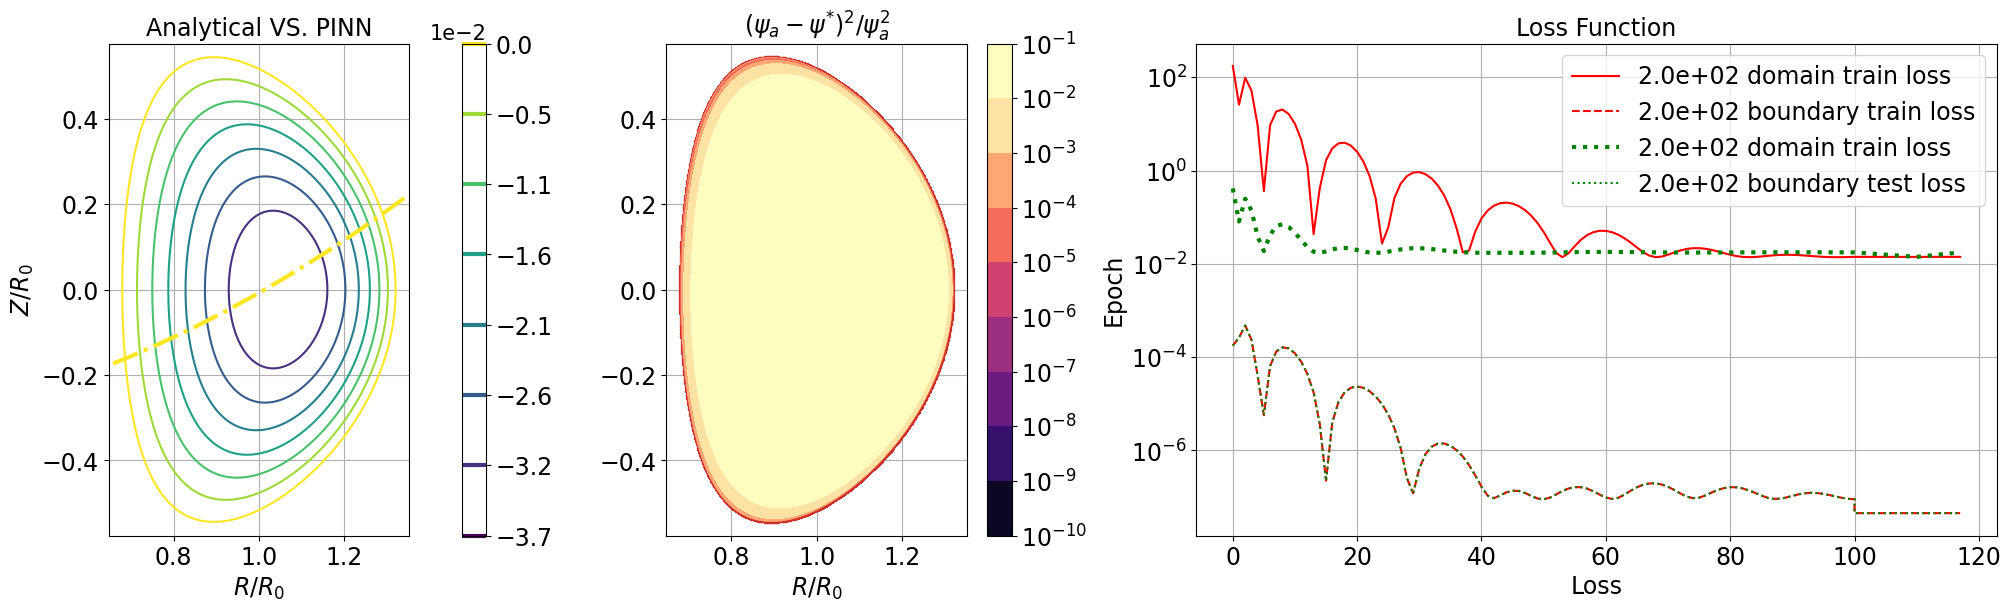

In [19]:
# Evaluation
x, y, psi_pred, psi_true, error = evaluate(ITER, model)
# x_eq, psi_true_eq, psi_pred_eq, e_eq = evaluate_eq(ITER, model)
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test, losshistory = loss_history, loss_ratio = LOSSRATIO, PATH = PATH)

True volume =  0.5391868755298623
predicted volume =  0.2500819156642027
True Cp =  2.769978961180589
predicted Cp =  0.9762084126474656
True qstar =  1.545229123372812
True beta_p =  1.229505475022825
True beta_t =  0.052728407379333125
True beta =  0.05056009395155794
Predicted qstar =  0.5445765801273401
Predicted beta_p =  3.8596077958862796
Predicted beta_t =  1.3326779466585557
Predicted beta =  0.9906261803319207
Relative Error volume =  0.5361869381215082
Relative Error Cp =  0.6475755136308338
Relative Error qstar =  0.6475755136308339
Relative Error beta_p =  -2.1391546229711818
Relative Error beta_t =  -24.27438268846516
Relative Error beta =  -18.593044690167076


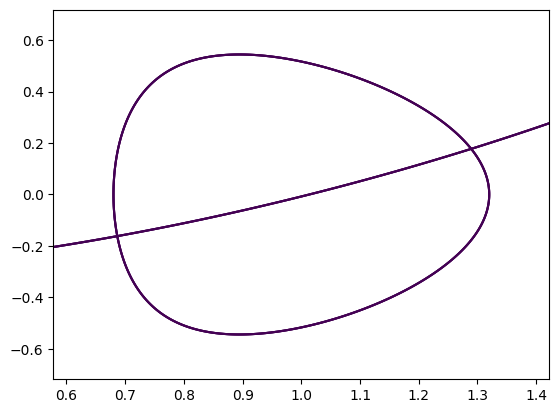

In [20]:
engineering_params = compute_params(x, y, psi_true, psi_pred)